## Analisi di Spiegabilità (XAI) per Modelli GNN su Dati di Brain-Imaging

### *Notebook di Analisi Esplicativa*

In questo notebook, esploreremo le predizioni di un modello Graph Neural Network (GNN) pre-addestrato per la segmentazione di tumori cerebrali. L'obiettivo non è solo valutare l'accuratezza, ma capire **perché** il modello prende determinate decisioni. Utilizzeremo diverse tecniche di Explainable AI (XAI) per identificare le feature, i nodi vicini e le connessioni più influenti.

---

## 1. Setup dell'Ambiente e Importazioni

Iniziamo importando le librerie necessarie e configurando l'ambiente di lavoro.

- **Librerie Core:** `os`, `sys`, `numpy` per la gestione del sistema e operazioni numeriche.
- **PyTorch & PyG:** `torch` è il framework di base; `torch_geometric` è la libreria essenziale per i GNN.
- **MONAI:** Utilizziamo `set_determinism` per garantire la riproducibilità degli esperimenti, un aspetto cruciale nell'analisi XAI.
- **Explainability:** Importiamo `Explainer` e `GNNExplainer` da PyG, che sono gli strumenti principali per questa analisi.
- **Visualizzazione:** `matplotlib` per la creazione di grafici.

In [1]:
# --- Librerie di base e di sistema ---
import os
import sys
import random
from sys import platform

# --- Gestione dei percorsi ---
sys.path.append('..')

# --- Framework e librerie GNN ---
import torch
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import GNNExplainer
import numpy as np

# --- Librerie ausiliarie e di visualizzazione ---
from monai.utils import set_determinism
from src.helpers.config import get_config
from src.models.gnn import GraphSAGE, GAT, ChebNet
import matplotlib.pyplot as plt
import time

## 2. Configurazione e Riproducibilità

### 2.1 Definizione dei Percorsi
Carichiamo le configurazioni e definiamo i percorsi principali per i dati, i modelli e i report.

In [2]:
# Definisce il percorso base (la cartella principale del progetto)
_base_path = os.path.abspath('..')

# Definizione dei percorsi
_config = get_config()
data_path = os.path.join(_base_path, _config.get('DATA_FOLDER'))
graph_path = os.path.join(data_path, _config.get('GRAPH_FOLDER'))
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))

if platform == 'win32':
    data_path = data_path.replace('/', '\\')
    graph_path = graph_path.replace('/', '\\')
    saved_path = saved_path.replace('/', '\\')
    reports_path = reports_path.replace('/', '\\')
    logs_path = logs_path.replace('/', '\\')

### 2.2 Seed per la Riproducibilità
L'analisi di spiegabilità può avere componenti stocastiche. Fissare un seed è fondamentale per garantire che i risultati siano consistenti e confrontabili tra diverse esecuzioni.

In [3]:
# Impostare un seed per la riproducibilità
set_determinism(seed=3)
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

## 3. Definizione del Modello e dei Dati

### 3.1 Classi di Output
Definiamo i nomi delle classi target. Questo mapping da indici numerici a etichette testuali sarà essenziale per interpretare i risultati in modo intuitivo.

In [4]:
# --- Definizione delle Classi di Output ---
# Si mappa l'indice numerico di ogni classe a un'etichetta testuale
# per rendere più interpretabili i risultati e i grafici.

classes = [
    "Sano/Background",      # Classe 0
    "NCR/NET",              # Classe 1 (Nucleo Necrotico/Non-Enhancing)
    "Edema (ED)",           # Classe 2
    "Tumore Enhancing (ET)" # Classe 3
]

### 3.2 Architettura del Modello GNN
Qui definiamo l'architettura del nostro modello. Per questa analisi, utilizzeremo **ChebNet**, una Graph Convolutional Network basata su approssimazioni spettrali con polinomi di Chebyshev.

**Scelta di ChebNet:**
- **Localizzazione Spettrale:** Permette di definire filtri che operano in un intorno localizzato del grafo.
- **Efficienza:** Computazionalmente vantaggioso rispetto ad altri metodi spettrali.
- **Parametro K:** L'ordine del polinomio `K` definisce la dimensione del vicinato considerato da ogni "neurone" (K-hop neighborhood), un parametro chiave per l'interpretabilità.

In [5]:
# --- Definizione degli Iperparametri ---
# Iperparametri per la configurazione del modello ChebNet.

# Parametri dell'architettura
num_node_features = 50          # Dimensione delle feature di input per ogni nodo
num_classes = 4                 # Numero di classi di output (target)
dropout = .0                    # Tasso di dropout (disattivato in fase di analisi)
hidden_channels = [512, 512, 512, 512, 512, 512, 512]  # Unità per ogni layer nascosto

# Parametri specifici di ChebNet
k = 4                           # Ordine K del polinomio di Chebyshev (ampiezza del vicinato)

# --- Istanziazione del Modello ---
# Si crea un'istanza del modello, pronta per caricare i pesi pre-addestrati.
model = ChebNet(
    in_channels=num_node_features,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    dropout=dropout,
    K=k
)

# Stampa di conferma della creazione del modello
print(f"Modello creato: {model.__class__.__name__}")

Modello creato: ChebNet


## 4. Caricamento Dati e Selezione del Target di Analisi

### 4.1 Funzione di Caricamento
Questa funzione helper si occupa di caricare un singolo grafo (paziente) dal disco.

In [6]:
# --- Funzione Helper per il Caricamento Dati ---
# Funzione per caricare i dati di un singolo paziente (grafo) dal disco.

def find_and_load_graph(subject_id):
    """
    Trova e carica il file di un grafo dato l'ID del soggetto.
    
    Args:
        subject_id (str): ID univoco del soggetto.
        
    Returns:
        (torch_geometric.data.Data, str): Tupla con il grafo e il suo ID.
    """
    # Costruisce il path completo del file .graph
    graph_file = os.path.join(graph_path, subject_id, f"{subject_id}.graph")
    
    # Controllo di sicurezza: verifica che il file esista
    if not os.path.isfile(graph_file):
        raise FileNotFoundError(f"File grafo non trovato per il soggetto {subject_id}")
    
    # Messaggio di log per tracciare il processo
    print(f"Caricamento grafo: {graph_file}")
    
    # Carica il grafo (oggetto Data di PyTorch Geometric)
    data = torch.load(graph_file, weights_only=False)
    
    return data, subject_id

In [7]:
# --- Caricamento del Grafo Specifico ---
# Questa cella carica il grafo del soggetto identificato dalla variabile SUBJECT_ID_TO_LOAD.

# Imposta un ID di default se la variabile non è definita (utile per testare la cella).
if 'SUBJECT_ID_TO_LOAD' not in locals():
    SUBJECT_ID_TO_LOAD = "BraTS-GLI-00577-000"
    print(f"ATTENZIONE: SUBJECT_ID_TO_LOAD non definito. Uso il default: {SUBJECT_ID_TO_LOAD}")

# Tenta di caricare il grafo, gestendo possibili errori di I/O.
try:
    print(f"--- Inizio caricamento per il soggetto: {SUBJECT_ID_TO_LOAD} ---")
    data, subject_id = find_and_load_graph(SUBJECT_ID_TO_LOAD)
    
    # Stampa un riepilogo delle proprietà del grafo caricato.
    print(f"Grafo caricato con successo: {subject_id}")
    print(f"  - Numero di nodi: {data.num_nodes}")
    print(f"  - Numero di archi: {data.num_edges}")
    print(f"  - Numero di feature per nodo: {data.num_node_features}")

except (FileNotFoundError, IOError) as e:
    # Se il file non esiste, notifica l'errore e interrompe l'esecuzione del notebook.
    print(f"ERRORE: {e}")
    raise e

ATTENZIONE: SUBJECT_ID_TO_LOAD non definito. Uso il default: BraTS-GLI-00577-000
--- Inizio caricamento per il soggetto: BraTS-GLI-00577-000 ---
Caricamento grafo: C:\Users\gianluca\Desktop\brain-tumor-graph-segmentation-main\data\graphs\BraTS-GLI-00577-000\BraTS-GLI-00577-000.graph
Grafo caricato con successo: BraTS-GLI-00577-000
  - Numero di nodi: 2901
  - Numero di archi: 29010
  - Numero di feature per nodo: 50


### 4.2 Pannello di Controllo dell'Analisi
Qui definiamo:
1.  **Quale paziente (`subject_id`) analizzare.**
2.  **Come selezionare il nodo (`NODE_SELECTION_METHOD`)** da spiegare all'interno del grafo del paziente.

Questo approccio permette di rieseguire l'analisi su target diversi in modo rapido e controllato.

In [8]:
# ======================================================================
#                   PANNELLO DI CONTROLLO DELL'ANALISI
# ======================================================================
# Parametri per configurare l'analisi di spiegabilità (XAI) del modello.
# Modificare queste variabili per cambiare il target dello studio.

# --- 1. Selezione del Soggetto ---
# ID del soggetto (paziente/grafo) da analizzare.
SUBJECT_ID_TO_LOAD = "BraTS-GLI-00017-001"


# --- 2. Criterio di Selezione del Nodo da Spiegare ---
# Metodo per scegliere il nodo target per l'analisi XAI.
#
# Opzioni disponibili:
# 'highest_confidence': Nodo corretto con la predizione più sicura.
# 'lowest_confidence':  Nodo corretto con la predizione più incerta.
# 'first_incorrect':    Primo nodo classificato in modo errato.
# 'random_correct':     Un nodo corretto scelto casualmente.
# 'random_incorrect':   Un nodo errato scelto casualmente.
# 'specific_class':     Un nodo di una classe di tessuto specifica.
# 'specific_index':     Un nodo specifico identificato dal suo indice.
NODE_SELECTION_METHOD = 'lowest_confidence'

# --- Parametri Specifici per la Selezione ---

# Utilizzato se il metodo è 'specific_class'.
# Mapping: 0:Sano, 1:NCR/NET, 2:Edema, 3:Tumore Enhancing (ET)
TARGET_CLASS_FOR_SELECTION = 3

# Utilizzato se il metodo è 'specific_index'.
TARGET_INDEX_FOR_SELECTION = 847

# --- Riepilogo della Configurazione ---
# Stampa le impostazioni correnti per una rapida verifica.
print("--- Configurazione dell'analisi impostata ---")
print(f"Grafo da caricare: {SUBJECT_ID_TO_LOAD}")
print(f"Criterio di selezione del nodo: {NODE_SELECTION_METHOD}")

# Mostra i parametri aggiuntivi solo se pertinenti.
if NODE_SELECTION_METHOD == 'specific_class':
    print(f"Classe target per la selezione: {TARGET_CLASS_FOR_SELECTION} ({classes[TARGET_CLASS_FOR_SELECTION]})")
if NODE_SELECTION_METHOD == 'specific_index':
    print(f"Indice specifico del nodo target: {TARGET_INDEX_FOR_SELECTION}")

--- Configurazione dell'analisi impostata ---
Grafo da caricare: BraTS-GLI-00017-001
Criterio di selezione del nodo: lowest_confidence


### 4.3 Caricamento del Modello Pre-addestrato e Valutazione
Ora carichiamo i pesi del miglior modello ChebNet salvato durante l'addestramento e verifichiamo la sua performance sul grafo selezionato. Questo ci dà un contesto sull'affidabilità delle predizioni che andremo a spiegare.

In [9]:
# --- Caricamento del Modello Pre-addestrato ---
# Carica i pesi del miglior modello ChebNet salvato durante l'addestramento.

# Cerca tutti i file del modello "best" nella directory di salvataggio.
model_files = [f for f in os.listdir(saved_path) if 'CHEBNET' in f and f.endswith('_best.pth')]

# Solleva un errore se non viene trovato nessun file del modello.
if not model_files:
    raise FileNotFoundError("Nessun modello ChebNet pre-addestrato trovato.")

# Ordina i file (tipicamente per timestamp nel nome) e seleziona il più recente.
latest_model = sorted(model_files)[-1]
print(f"Utilizzo del modello pre-addestrato: {latest_model}")

# Carica i pesi (state_dict) nel modello, mappandoli sulla CPU per portabilità.
model.load_state_dict(torch.load(os.path.join(saved_path, latest_model), map_location=torch.device('cpu')))

# Imposta il modello in modalità valutazione (disattiva dropout, batch norm, etc.).
model.eval()

Utilizzo del modello pre-addestrato: CHEBNET_1739029370_best.pth


ChebNet(
  (layers): ModuleList(
    (0): ChebConv(50, 512, K=4, normalization=sym)
    (1-6): 6 x ChebConv(512, 512, K=4, normalization=sym)
    (7): ChebConv(512, 4, K=4, normalization=sym)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

## **Valutazione dell'Accuratezza**

- Verifica dell'accuratezza del modello sul grafo caricato.

In [10]:
# --- Esecuzione della Predizione sul Grafo ---
# Si esegue l'inferenza sul grafo caricato per ottenere le etichette
# predette dal modello e calcolare l'accuratezza su questo singolo caso.

# Blocco di inferenza: disattiva il calcolo dei gradienti per efficienza.
with torch.no_grad():
    # 1. Genera gli output (logits) del modello per ogni nodo.
    outputs = model(data.x, data.edge_index.type(torch.int64))
    
    # 2. Converte i logits in etichette di classe (la classe con il valore massimo).
    predicted_labels = outputs.argmax(dim=1)

# --- Calcolo dell'Accuratezza sul Grafo ---
try:
    # Confronta le predizioni con le etichette reali (ground truth).
    correct_predictions = (predicted_labels == data.y.long())
    accuracy = correct_predictions.float().mean().item()
    print(f"Accuratezza del modello sul grafo {subject_id}: {accuracy:.4f}")
except Exception as e:
    # Gestisce il caso in cui le etichette 'data.y' non siano disponibili.
    print(f"Avviso: impossibile calcolare l'accuratezza (etichette mancanti?). Errore: {e}")

# --- Riepilogo delle Classi Predette ---
# Conta le occorrenze di ogni classe predetta per avere una visione d'insieme.
class_counts = torch.bincount(predicted_labels, minlength=num_classes)
print(f"Distribuzione delle classi predette: {class_counts.numpy()}")

Accuratezza del modello sul grafo BraTS-GLI-00577-000: 0.9924
Distribuzione delle classi predette: [2687   34  112   68]


In [11]:
# --- Selezione Automatica del Nodo Target per l'Analisi XAI ---
# Questa cella implementa la logica definita in NODE_SELECTION_METHOD per scegliere
# un nodo specifico (superpixel) la cui predizione verrà spiegata.

import torch.nn.functional as F

print("\n--- Inizio selezione del nodo target ---")

# --- 1. Preparazione dei Dati per la Selezione ---
# Calcola le probabilità (softmax) per ogni nodo e la confidenza della predizione.
with torch.no_grad():
    all_logits = model(data.x, data.edge_index.type(torch.int64))
    all_probs = F.softmax(all_logits, dim=1)
    max_probs, _ = torch.max(all_probs, dim=1) # Confidenza della classe predetta

# Crea maschere booleane per filtrare i nodi corretti e quelli errati.
correct_preds_mask = (predicted_labels == data.y.long())
incorrect_preds_mask = ~correct_preds_mask

# --- 2. Applicazione della Strategia di Selezione ---
# In base al metodo scelto, identifica un insieme di nodi "candidati".
selected_node_index = -1

if NODE_SELECTION_METHOD == 'highest_confidence':
    # Trova il nodo corretto con la massima probabilità.
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmax()].item()

elif NODE_SELECTION_METHOD == 'lowest_confidence':
    # Trova il nodo corretto con la minima probabilità (ma comunque > 0.5).
    low_conf_mask = (max_probs > 0.5)
    candidates = (correct_preds_mask & low_conf_mask).nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmin()].item()

elif NODE_SELECTION_METHOD == 'first_incorrect':
    # Seleziona il primo nodo classificato erroneamente.
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[0].item()

elif NODE_SELECTION_METHOD == 'random_correct':
    # Sceglie un nodo corretto in modo casuale.
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'random_incorrect':
    # Sceglie un nodo errato in modo casuale.
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'specific_class':
    # Sceglie un nodo casuale appartenente a una classe specifica.
    class_mask = (predicted_labels == TARGET_CLASS_FOR_SELECTION)
    candidates = class_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = random.choice(candidates.tolist())

elif NODE_SELECTION_METHOD == 'specific_index':
    # Usa l'indice fornito manualmente dal pannello di controllo.
    selected_node_index = TARGET_INDEX_FOR_SELECTION

# --- 3. Gestione del Fallback e Riepilogo ---
# Fallback: se nessun nodo soddisfa i criteri, ne sceglie uno casuale per evitare errori.
if selected_node_index == -1:
    print(f"ATTENZIONE: Nessun nodo trovato con il metodo '{NODE_SELECTION_METHOD}'. Seleziono un nodo casuale.")
    selected_node_index = random.randint(0, data.num_nodes - 1)

# Salva l'indice del nodo selezionato per l'uso nelle celle successive.
node_to_explain_index = selected_node_index

# Stampa le informazioni chiave del nodo scelto per una rapida verifica.
pred_class_idx = predicted_labels[node_to_explain_index].item()
real_class_idx = data.y[node_to_explain_index].long().item()

print(f"\n---> NODO SELEZIONATO PER L'ANALISI: Indice {node_to_explain_index} <---")
print(f"  - Classe Predetta: {classes[pred_class_idx]} (Prob: {max_probs[node_to_explain_index]:.4f})")
print(f"  - Classe Reale:    {classes[real_class_idx]}")
print(f"  - Esito Predizione:  {'Corretta' if pred_class_idx == real_class_idx else 'ERRATA'}")


--- Inizio selezione del nodo target ---

---> NODO SELEZIONATO PER L'ANALISI: Indice 1048 <---
  - Classe Predetta: Edema (ED) (Prob: 0.6604)
  - Classe Reale:    Edema (ED)
  - Esito Predizione:  Corretta


## 5. Tecniche di Spiegabilità (XAI)

Applicheremo tre diverse tecniche XAI per ottenere una visione completa e robusta di ciò che il modello ha imparato.

### 5.1 Metodo Basato sul Modello: GNNExplainer
**GNNExplainer** è un metodo *model-specific* che apprende una maschera "soft" sul grafo di calcolo del nodo target. Cerca di trovare il sottografo e il sottoinsieme di feature più piccoli ma più influenti per la predizione.

- **Cosa Spiega:** L'importanza di **feature** e **archi (vicini)**.
- **Come Funziona:** Ottimizza una maschera per massimizzare l'informazione mutua tra la predizione del modello e la distribuzione del sottografo.
- **Punti di Forza:** Fornisce una spiegazione strutturata (sottografo) e basata sulle feature.

In [12]:
# ======================================================================
#         METODO DI SPIEGABILITÀ 1: GNNEXPLAINER
# ======================================================================
# Usa GNNExplainer per identificare il sottografo e le feature più influenti
# per la predizione del nodo target selezionato.

import torch.nn.functional as F

# --- 1. Configurazione dell'Algoritmo GNNExplainer ---
# Si definiscono gli iperparametri dell'algoritmo di spiegazione.
# I coefficienti (coeffs) servono a regolarizzare l'output, promuovendo
# spiegazioni "sparse" (poche feature e pochi archi importanti).
gnn_explainer_algorithm = GNNExplainer(
    epochs=200,
    lr=0.01,
    coeffs={
        "edge_size": 0.005,      # Penalità per non rendere il sottografo troppo grande.
        "node_feat_size": 1.0,   # Penalità per non usare troppe feature.
        "edge_ent": 1.0,         # Incentivo a dare importanza "decisa" (0 o 1) agli archi.
        "node_feat_ent": 0.1,    # Incentivo a dare importanza "decisa" alle feature.
    }
)

# --- 2. Configurazione dell'Oggetto Explainer ---
# Si configura l'oggetto `Explainer` che orchestra il processo di spiegazione.

# Specifica come funziona il nostro modello: classificazione di nodi che restituisce logits ('raw').
model_config = ModelConfig(
    mode="multiclass_classification",
    task_level="node",
    return_type="raw" # Il nostro modello restituisce logits, non probabilità.
)

# Unisce il modello, l'algoritmo (GNNExplainer) e la configurazione.
explainer = Explainer(
    model=model,
    algorithm=gnn_explainer_algorithm,
    explanation_type="phenomenon",
    model_config=model_config,
    node_mask_type="attributes",   # Spiega l'importanza delle singole feature di un nodo.
    edge_mask_type="object",       # Spiega l'importanza dei singoli archi.
)

# --- 3. Esecuzione della Spiegazione ---
# Si avvia il processo di spiegazione per il nodo target selezionato.
print(f"\n--- Esecuzione di GNNExplainer per il nodo: {node_to_explain_index} ---")
start_time = time.time()

# Genera la spiegazione per il nodo `index` usando le predizioni del modello come `target`.
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index.type(torch.int64),
    index=node_to_explain_index,
    target=predicted_labels.type(torch.LongTensor)
)

elapsed_time = time.time() - start_time
print(f"Spiegazione generata in {elapsed_time:.2f} secondi.")

# --- 4. Verifica dei Risultati ---
# Controlla che le maschere di importanza per nodi e archi siano state generate.
print("\n--- Riepilogo della Spiegazione Generata ---")
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:
    print(f"Ottenuta maschera di importanza per le feature (node_mask) di forma: {explanation.node_mask.shape}")
else:
    print("Maschera per le feature (node_mask) non generata.")

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    print(f"Ottenuta maschera di importanza per gli archi (edge_mask) di forma: {explanation.edge_mask.shape}")
else:
    print("Maschera per gli archi (edge_mask) non generata.")


--- Esecuzione di GNNExplainer per il nodo: 1048 ---
Spiegazione generata in 463.48 secondi.

--- Riepilogo della Spiegazione Generata ---
Ottenuta maschera di importanza per le feature (node_mask) di forma: torch.Size([2901, 50])
Ottenuta maschera di importanza per gli archi (edge_mask) di forma: torch.Size([29010])


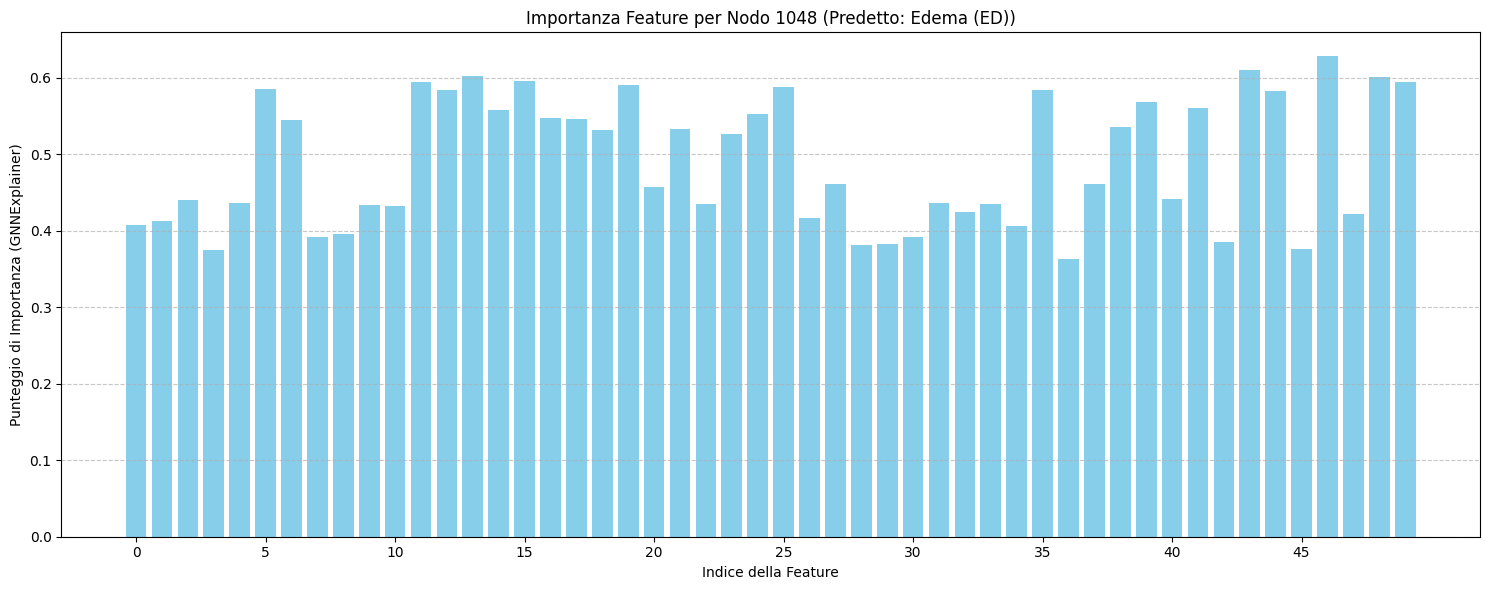


Le 10 feature più importanti per il nodo 1048:
  - Feature 46: Importanza = 0.6283
  - Feature 43: Importanza = 0.6108
  - Feature 13: Importanza = 0.6031
  - Feature 48: Importanza = 0.6017
  - Feature 15: Importanza = 0.5964
  - Feature 11: Importanza = 0.5947
  - Feature 49: Importanza = 0.5946
  - Feature 19: Importanza = 0.5912
  - Feature 25: Importanza = 0.5879
  - Feature 5: Importanza = 0.5855


In [13]:
# --- Analisi dell'Importanza delle Feature (GNNExplainer) ---
# Si analizza la `node_mask` per capire quali feature il modello ha ritenuto più
# importanti per la classificazione del nodo target.

# Esegue l'analisi solo se la maschera delle feature è stata generata correttamente.
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:

    # Estrae i punteggi di importanza per il solo nodo di interesse e li converte in NumPy.
    target_feature_importances = explanation.node_mask[node_to_explain_index].cpu().detach().numpy()
    
    # --- 1. Visualizzazione Grafica ---
    # Crea un grafico a barre per mostrare l'importanza di ogni singola feature.
    plt.figure(figsize=(15, 6))
    bar_positions = np.arange(num_node_features)
    plt.bar(bar_positions, target_feature_importances, color='skyblue')
    
    plt.xlabel("Indice della Feature")
    plt.ylabel("Punteggio di Importanza (GNNExplainer)")
    plt.title(f"Importanza Feature per Nodo {node_to_explain_index} (Predetto: {classes[predicted_labels[node_to_explain_index].item()]})")
    plt.xticks(bar_positions[::5]) # Mostra tick ogni 5 feature per una migliore leggibilità.
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- 2. Riepilogo Quantitativo (Top N) ---
    # Identifica e stampa le N feature con il punteggio più alto.
    k_top_features = 10
    
    # Ordina gli indici delle feature in base al loro punteggio (dal più alto al più basso).
    sorted_feature_indices = np.argsort(target_feature_importances)[::-1]
    
    print(f"\nLe {k_top_features} feature più importanti per il nodo {node_to_explain_index}:")
    for i in range(min(k_top_features, num_node_features)):
        feat_idx = sorted_feature_indices[i]
        importance = target_feature_importances[feat_idx]
        print(f"  - Feature {feat_idx}: Importanza = {importance:.4f}")
        
else:
    # Messaggio di errore se la maschera delle feature non è disponibile.
    print("Analisi non eseguibile: la maschera delle feature (node_mask) non è stata generata.")


--- Analisi degli Archi e Vicini per il Nodo Target: 1048 ---

Le 15 connessioni più importanti per il nodo 1048:
Arco (u, v)     Importanza      Classe Nodo U             Classe Nodo V            
--------------------------------------------------------------------------------
(1048-1353)      0.5730          Edema (ED)                Sano/Background          
(1048-1356)      0.5681          Edema (ED)                Sano/Background          
(1109-1048)      0.4734          Edema (ED)                Edema (ED)               
(1352-1048)      0.4480          Sano/Background           Edema (ED)               
(1028-1048)      0.4329          Tumore Enhancing (ET)     Edema (ED)               
(1204-1048)      0.4285          Edema (ED)                Edema (ED)               
(1013-1048)      0.4282          Tumore Enhancing (ET)     Edema (ED)               
(1233-1048)      0.4247          Sano/Background           Edema (ED)               
(1108-1048)      0.4169          Edema (

C:\Users\gianluca\AppData\Local\Temp\ipykernel_4092\873019869.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


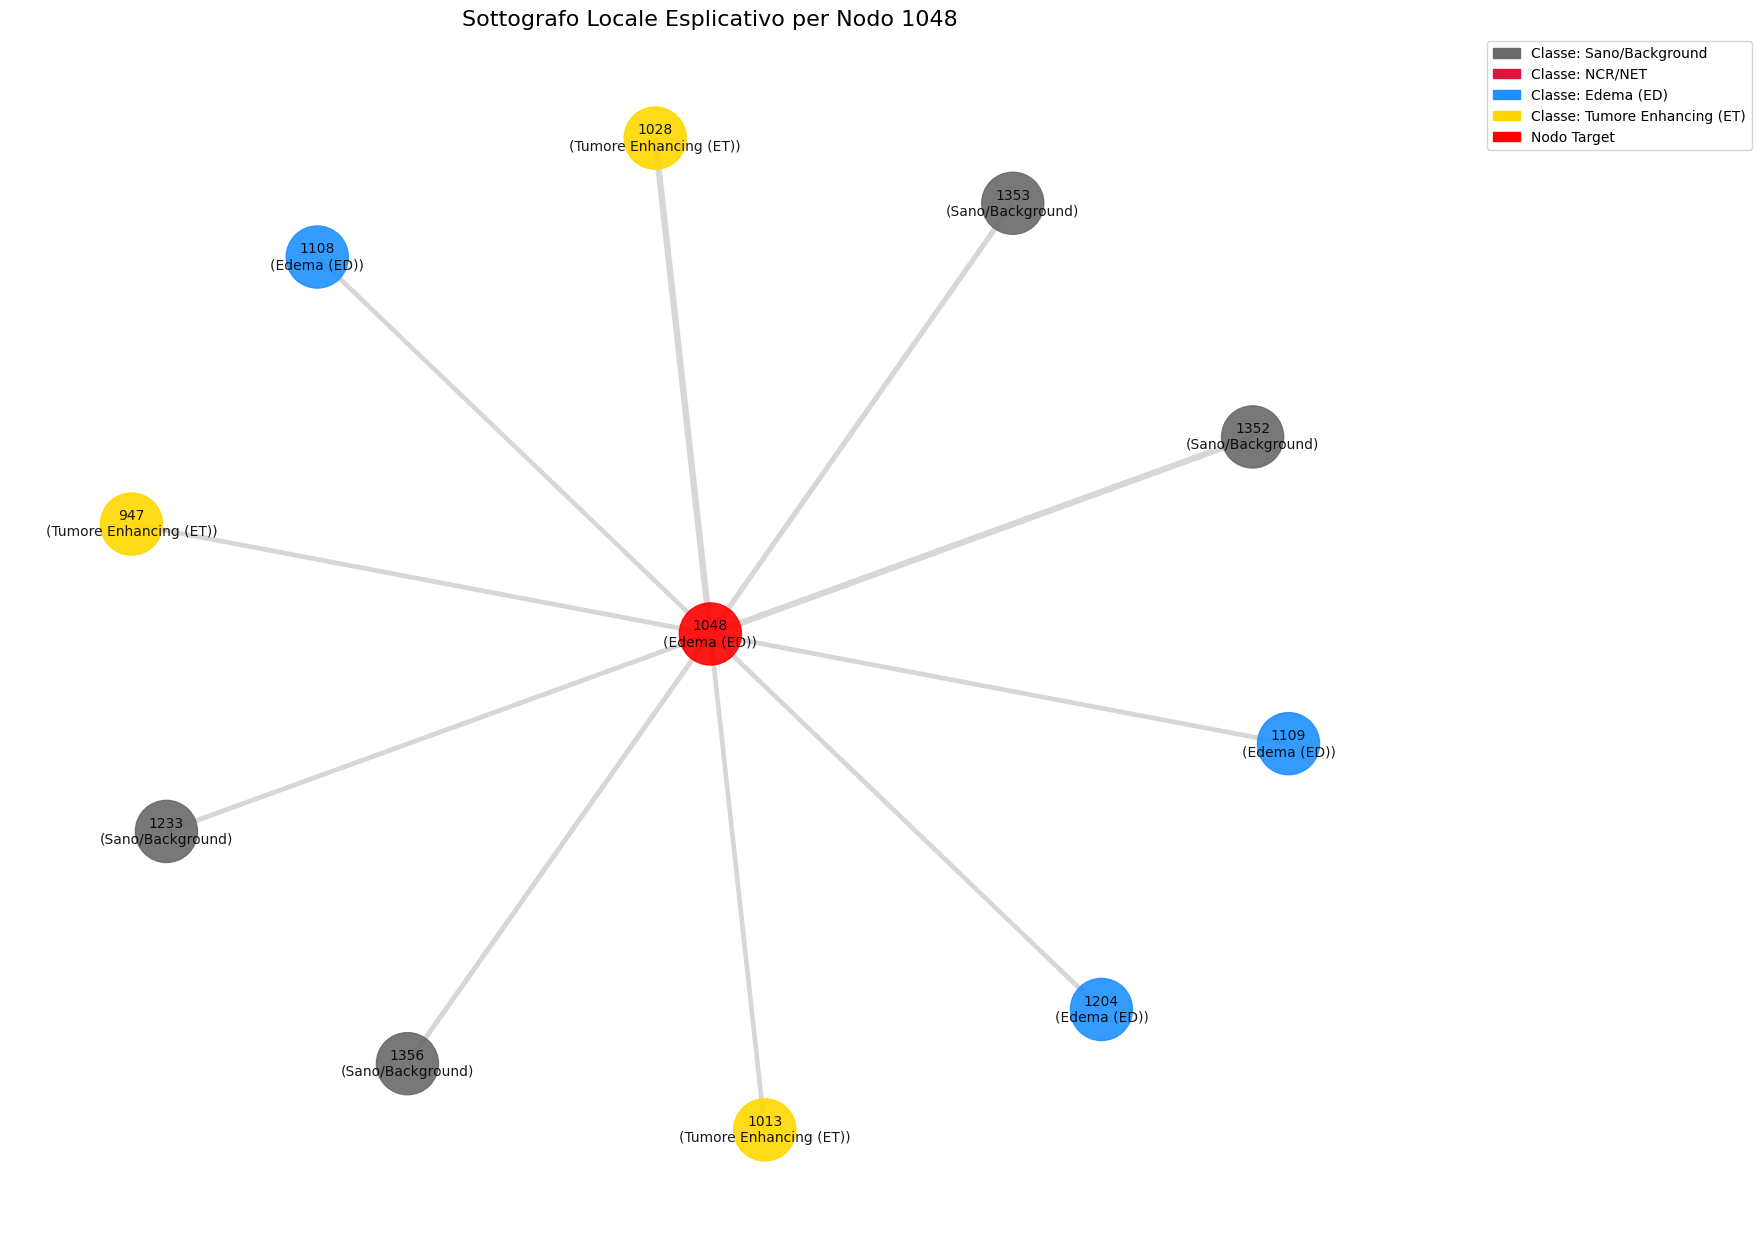

In [14]:
# --- Analisi del Sottografo Esplicativo (GNNExplainer) ---
# Si analizza la `edge_mask` per identificare quali nodi vicini e quali
# connessioni sono stati più influenti per la predizione del nodo target.

# Esegue l'analisi solo se la maschera degli archi è stata generata.
if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    edge_importances = explanation.edge_mask.cpu().detach().numpy()
    edge_index = data.edge_index.cpu().numpy()

    print(f"\n--- Analisi degli Archi e Vicini per il Nodo Target: {node_to_explain_index} ---")
    
    # --- 1. Estrazione e Filtraggio degli Archi Rilevanti ---
    # Isola tutti gli archi connessi al nodo target e li ordina per importanza.
    connected_edges_info = []
    for i in range(edge_index.shape[1]):
        u, v = int(edge_index[0, i]), int(edge_index[1, i])
        if u == node_to_explain_index or v == node_to_explain_index:
            # Salva una tupla (importanza, nodo_sorgente, nodo_destinazione).
            connected_edges_info.append((edge_importances[i], u, v))
    
    # Ordina la lista in base al punteggio di importanza (dal più alto al più basso).
    connected_edges_info.sort(key=lambda x: x[0], reverse=True)

    # --- 2. Riepilogo Tabellare (Top N Archi) ---
    # Stampa una tabella con le connessioni più importanti per un'analisi dettagliata.
    k_top_edges = 15
    print(f"\nLe {k_top_edges} connessioni più importanti per il nodo {node_to_explain_index}:")
    print(f"{'Arco (u, v)':<15} {'Importanza':<15} {'Classe Nodo U':<25} {'Classe Nodo V':<25}")
    print("-" * 80)

    if not connected_edges_info:
        print("Nessun arco rilevante trovato per questo nodo.")
    else:
        for importance, u, v in connected_edges_info[:k_top_edges]:
            class_u = classes[int(predicted_labels[u].item())]
            class_v = classes[int(predicted_labels[v].item())]
            print(f"({u}-{v}){'':<5} {importance:<15.4f} {class_u:<25} {class_v:<25}")

    # --- 3. Visualizzazione del Sottografo Esplicativo ---
    # Crea un grafico del vicinato del nodo target, evidenziando le connessioni più forti.
    try:
        import networkx as nx
        import matplotlib.patches as mpatches
        
        # Identifica i nodi vicini più importanti sommando l'importanza degli archi condivisi.
        neighbor_importance = {}
        for importance, u, v in connected_edges_info:
            neighbor_node = v if u == node_to_explain_index else u
            neighbor_importance[neighbor_node] = neighbor_importance.get(neighbor_node, 0) + importance
        
        # Seleziona i nodi da visualizzare: il target e i suoi N vicini più influenti.
        top_neighbors = sorted(neighbor_importance.items(), key=lambda item: item[1], reverse=True)[:k_top_edges]
        nodes_to_plot = {node_to_explain_index}.union({n[0] for n in top_neighbors})
        
        # Configura il grafico: nodi, colori (per classe) e etichette.
        G = nx.Graph()
        color_map = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'} # Sano, NCR, Edema, ET
        node_colors = []
        node_labels = {}
        for node in nodes_to_plot:
            G.add_node(node)
            class_idx = int(predicted_labels[node].item())
            node_labels[node] = f"{node}\n({classes[class_idx]})"
            node_colors.append('red' if node == node_to_explain_index else color_map.get(class_idx, 'grey'))

        # Aggiunge gli archi, usando l'importanza per definirne lo spessore.
        edges_to_plot = []
        edge_widths = []
        for importance, u, v in connected_edges_info:
            if u in nodes_to_plot and v in nodes_to_plot and len(edges_to_plot) < k_top_edges:
                edges_to_plot.append((u, v))
                edge_widths.append(max(0.2, importance * 8)) # Scala l'importanza in spessore.
        G.add_edges_from(edges_to_plot)

        # Disegna il grafico utilizzando un layout a molla (spring layout).
        plt.figure(figsize=(14, 12))
        pos = nx.spring_layout(G, k=0.8, iterations=50, seed=3)
        nx.draw(G, pos, labels=node_labels, with_labels=True, 
                node_color=node_colors, node_size=2000, font_size=10, 
                width=edge_widths, font_color='black', edge_color='lightgray', alpha=0.9)

        # Aggiunge una legenda per rendere il grafico auto-esplicativo.
        legend_patches = [mpatches.Patch(color=color, label=f'Classe: {name}') for name, color in zip(classes, color_map.values())]
        legend_patches.append(mpatches.Patch(color='red', label='Nodo Target'))
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.title(f"Sottografo Locale Esplicativo per Nodo {node_to_explain_index}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

    except ImportError:
        print("Avviso: NetworkX non installato. La visualizzazione del grafo è stata saltata.")

else:
    # Messaggio di errore se la maschera degli archi non è disponibile.
    print("Analisi non eseguibile: la maschera degli archi (edge_mask) non è stata generata.")

#### Interpretazione dei Risultati di GNNExplainer

1.  **Importanza delle Feature (Grafico a Barre):** Il primo grafico mostra quali delle 50 feature di input sono state più importanti per la classificazione del nodo target. Valori alti indicano che GNNExplainer ha ritenuto quelle feature cruciali.
2.  **Importanza degli Archi (Tabella e Grafo):** La tabella e il grafo locale mostrano quali connessioni (e quindi quali vicini) hanno avuto il maggiore impatto. L'importanza aggregata degli archi ci dice quali vicini sono più influenti nel loro insieme.


### 5.2 Metodo Basato sul Gradiente: Integrated gradients

Integrated Gradients (IG) è un metodo che attribuisce a ciascuna feature di input un punteggio di importanza per una data predizione. Lo fa sommando (integrando) i gradienti lungo un percorso che va da un input "vuoto" (baseline) a quello reale, fornendo così una spiegazione più affidabile.

    Cosa Spiega: L'importanza delle singole feature del nodo target.

    Come Funziona: Somma i gradienti lungo un percorso che va da un input di riferimento (es. un vettore nullo) a quello effettivo. Questo attribuisce a ogni feature una "parte del merito" per la predizione.

    Punti di Forza: È un metodo model-agnostic (funziona con qualsiasi modello basato su gradienti) e i suoi risultati sono più affidabili dei gradienti semplici


--- Esecuzione di Integrated Gradients per il nodo: 1048 ---


C:\Users\gianluca\Desktop\brain-tumor-graph-segmentation-main\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classe predetta da spiegare: Edema (ED)


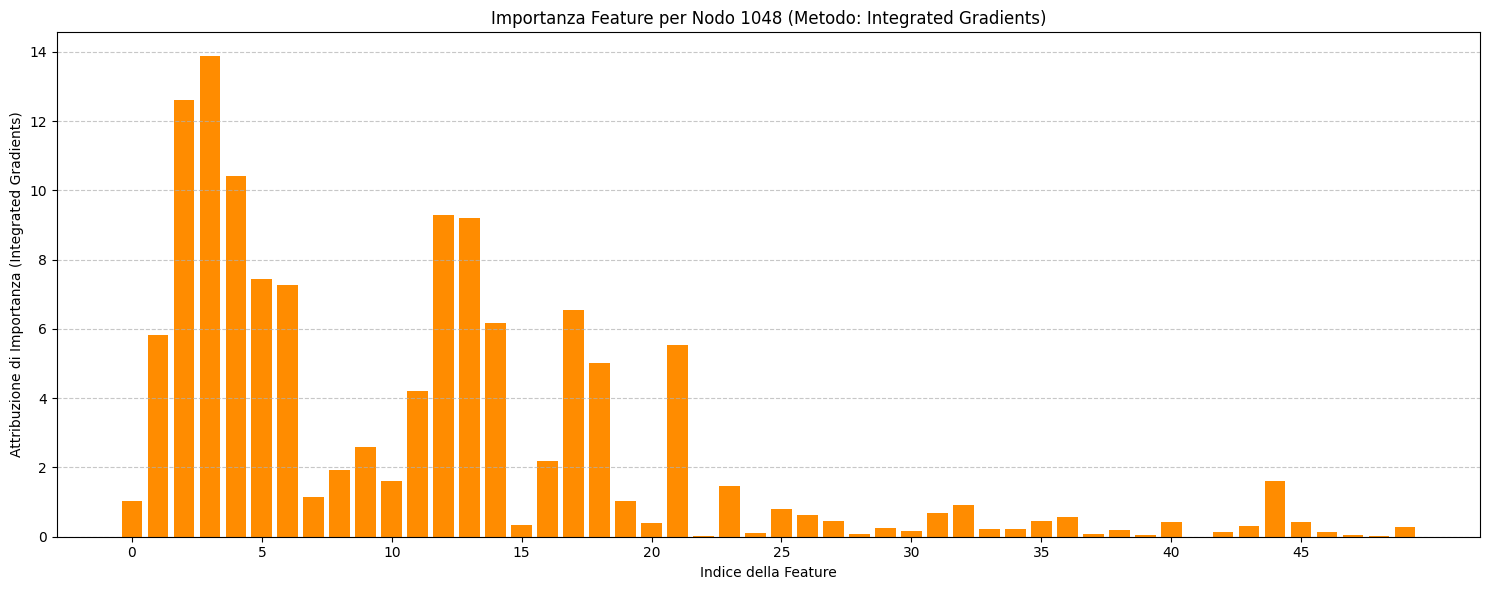


Le 10 feature più importanti per il nodo 1048 (secondo IG):
  - Feature 3: Attribuzione = 13.8671
  - Feature 2: Attribuzione = 12.6164
  - Feature 4: Attribuzione = 10.4084
  - Feature 12: Attribuzione = 9.3017
  - Feature 13: Attribuzione = 9.2117
  - Feature 5: Attribuzione = 7.4508
  - Feature 6: Attribuzione = 7.2707
  - Feature 17: Attribuzione = 6.5360
  - Feature 14: Attribuzione = 6.1666
  - Feature 1: Attribuzione = 5.8341


In [15]:
# ======================================================================
#         METODO 2: INTEGRATED GRADIENTS (IG)
# ======================================================================
# Applica Integrated Gradients (IG) per calcolare l'attribuzione di importanza
# delle feature per la predizione del nodo target.

from torch_geometric.explain import Explainer, CaptumExplainer

print(f"\n--- Esecuzione di Integrated Gradients per il nodo: {node_to_explain_index} ---")

# --- 1. Inizializzazione dell'Algoritmo ---
# Si inizializza l'algoritmo, usando la libreria Captum (integrata in PyG) come motore.
ig_algorithm = CaptumExplainer('IntegratedGradients')

# --- 2. Configurazione dell'Explainer ---
# Si crea l'oggetto Explainer, combinando il modello, l'algoritmo IG e la configurazione del task.
explainer_ig = Explainer(
    model=model,
    algorithm=ig_algorithm,
    explanation_type="phenomenon",
    model_config=model_config,  # Stessa configurazione usata per GNNExplainer
    node_mask_type="attributes",  # Richiesta di attribuzione a livello di feature.
)

# --- 3. Esecuzione della Spiegazione ---
# Si avvia il calcolo. IG richiede una baseline (es. un input nullo)
# che in questo caso è gestita internamente dall'Explainer.
explanation_ig = explainer_ig(
    x=data.x,
    edge_index=data.edge_index.type(torch.int64),
    index=node_to_explain_index,
    target=predicted_labels.type(torch.LongTensor)
)

# --- 4. Estrazione dei Risultati ---
# Si estraggono i valori di attribuzione per il nodo target.
# Si usa il valore assoluto (.abs()) perché ci interessa la *magnitudo* dell'impatto
# di ogni feature, non la sua direzione (positiva o negativa).
ig_values = explanation_ig.node_mask[node_to_explain_index].abs().cpu().detach().numpy()

# Si adotta il nome 'saliency_map' per coerenza e leggibilità.
saliency_map = ig_values 

# --- 5. Visualizzazione e Riepilogo ---
target_class_idx = predicted_labels[node_to_explain_index].item()
print(f"Classe predetta da spiegare: {classes[target_class_idx]}")

# Crea un grafico a barre per visualizzare l'attribuzione di ogni feature.
plt.figure(figsize=(15, 6))
bar_positions = np.arange(num_node_features)
# Si usa un colore diverso (arancione) per distinguere visivamente i risultati da GNNExplainer.
plt.bar(bar_positions, ig_values, color='darkorange') 

plt.xlabel("Indice della Feature")
plt.ylabel("Attribuzione di Importanza (Integrated Gradients)")
plt.title(f"Importanza Feature per Nodo {node_to_explain_index} (Metodo: Integrated Gradients)")
plt.xticks(bar_positions[::5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Identifica e stampa le N feature con la più alta attribuzione di importanza.
k_top_features = 10
sorted_indices = np.argsort(ig_values)[::-1]

print(f"\nLe {k_top_features} feature più importanti per il nodo {node_to_explain_index} (secondo IG):")
for i in range(min(k_top_features, num_node_features)):
    feat_idx = sorted_indices[i]
    importance = ig_values[feat_idx]
    print(f"  - Feature {feat_idx}: Attribuzione = {importance:.4f}")

## 5.3 Metodo Basato sulla Perturbazione: Analisi dei Vicini

L'Analisi di Perturbazione dei Vicini è un approccio intuitivo e model-agnostic. Per capire l'importanza di un vicino, ne "oscuriamo" le feature (impostandole a zero) e osserviamo come cambia la predizione del nodo target.

    Cosa Spiega: L'importanza di ogni singolo vicino per la classificazione del nodo target.

    Come Funziona: Per ogni vicino, si azzerano le sue feature. Poi, si misura il calo di probabilità della classe predetta per il nodo target. Un calo di probabilità maggiore corrisponde a un'importanza maggiore del vicino.

    Punti di Forza: Molto intuitivo e non dipende dall'architettura interna del modello (model-agnostic)


--- Inizio Analisi di Perturbazione dei Vicini per il nodo: 1048 ---
Probabilità originale per la classe 'Edema (ED)': 0.6604
Trovati 10 vicini. Inizio ciclo di perturbazione...
Analisi completata in 7.10 secondi.


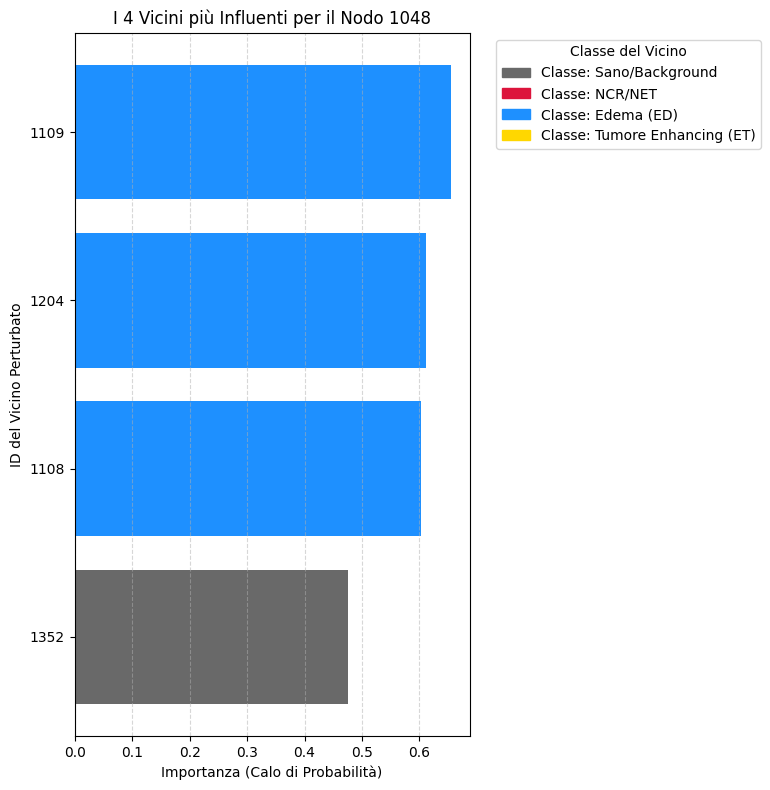


Importanza dei vicini (dal più al meno importante):
  - Rimuovere il vicino 1109 (Classe: Edema (ED)) causa un calo di prob. di 0.6544
  - Rimuovere il vicino 1204 (Classe: Edema (ED)) causa un calo di prob. di 0.6117
  - Rimuovere il vicino 1108 (Classe: Edema (ED)) causa un calo di prob. di 0.6025
  - Rimuovere il vicino 1352 (Classe: Sano/Background) causa un calo di prob. di 0.4750


In [16]:
# ======================================================================
#     METODO 3: ANALISI DI PERTURBAZIONE DEI VICINI
# ======================================================================
# Questo metodo "model-agnostic" valuta l'importanza di ogni vicino
# rimuovendolo (oscurando le sue feature) e misurando la conseguente
# variazione (calo) nella probabilità della predizione corretta.

import torch.nn.functional as F
import matplotlib.patches as mpatches
import time

print(f"\n--- Inizio Analisi di Perturbazione dei Vicini per il nodo: {node_to_explain_index} ---")

# --- 1. Calcolo della Predizione di Riferimento (Baseline) ---
# Si calcola la probabilità iniziale del nodo target, che servirà come base di confronto.
with torch.no_grad():
    original_probs = F.softmax(model(data.x, data.edge_index.type(torch.int64)), dim=1)
    target_class_idx = int(predicted_labels[node_to_explain_index].item())
    original_prob = original_probs[node_to_explain_index, target_class_idx].item()
    
print(f"Probabilità originale per la classe '{classes[target_class_idx]}': {original_prob:.4f}")

# --- 2. Identificazione dei Vicini ---
# Si raccolgono tutti i nodi direttamente connessi al nodo target.
edge_index_tensor = data.edge_index
neighbors_in = edge_index_tensor[0, edge_index_tensor[1] == node_to_explain_index]
neighbors_out = edge_index_tensor[1, edge_index_tensor[0] == node_to_explain_index]
all_neighbors = torch.unique(torch.cat([neighbors_in, neighbors_out]))

sorted_neighbors = [] # Inizializza per evitare errori se non ci sono vicini.

if len(all_neighbors) == 0:
    print(f"Il nodo {node_to_explain_index} non ha vicini. Analisi non eseguibile.")
else:
    print(f"Trovati {len(all_neighbors)} vicini. Inizio ciclo di perturbazione...")
    start_time = time.time()
    
    # --- 3. Ciclo di Perturbazione e Valutazione ---
    # Per ogni vicino, si crea una versione "perturbata" del grafo e si misura l'impatto.
    neighbor_importance_perturb = {}
    for neighbor_tensor in all_neighbors:
        neighbor_idx = int(neighbor_tensor.item())
        
        # Copia delle feature per evitare di modificare i dati originali.
        x_perturbed = data.x.clone()
        
        # Perturbazione: le feature del vicino vengono azzerate ("oscurate").
        x_perturbed[neighbor_idx, :] = 0.0
        
        # Si riesegue la predizione sul grafo perturbato.
        with torch.no_grad():
            perturbed_probs = F.softmax(model(x_perturbed, data.edge_index.type(torch.int64)), dim=1)
            new_prob = perturbed_probs[node_to_explain_index, target_class_idx].item()
        
        # L'importanza è definita come la differenza (calo) di probabilità.
        importance_score = original_prob - new_prob
        neighbor_importance_perturb[neighbor_idx] = importance_score

    print(f"Analisi completata in {time.time() - start_time:.2f} secondi.")
    
    # --- 4. Ordinamento e Filtraggio dei Risultati ---
    # Si ordinano i vicini per importanza e si filtrano quelli con impatto trascurabile.
    sorted_neighbors = sorted(
        [item for item in neighbor_importance_perturb.items() if item[1] > 1e-5], 
        key=lambda x: x[1], 
        reverse=True
    )
    
    # --- 5. Visualizzazione e Riepilogo dei Risultati ---
    if not sorted_neighbors:
        print("\nNessun impatto rilevabile dalla perturbazione dei vicini.")
    else:
        k_top_neighbors = 10
        top_k_to_plot = sorted_neighbors[:k_top_neighbors]
        
        neighbor_ids = [str(n[0]) for n in top_k_to_plot]
        importances = [n[1] for n in top_k_to_plot]
        
        # Si colorano le barre in base alla classe del vicino, per un'analisi più ricca.
        color_map = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'} # Sano, NCR, Edema, ET
        neighbor_classes = [int(predicted_labels[n[0]].item()) for n in top_k_to_plot]
        bar_colors = [color_map.get(cls, 'grey') for cls in neighbor_classes]

        # Grafico a barre orizzontale per una facile lettura dei nomi dei vicini.
        plt.figure(figsize=(10, 8))
        plt.barh(neighbor_ids[::-1], importances[::-1], color=bar_colors[::-1]) # Invertito per avere il più importante in alto.
        
        plt.xlabel("Importanza (Calo di Probabilità)")
        plt.ylabel("ID del Vicino Perturbato")
        plt.title(f"I {len(top_k_to_plot)} Vicini più Influenti per il Nodo {node_to_explain_index}")
        
        # Legenda per i colori delle classi.
        legend_patches = [mpatches.Patch(color=color, label=f'Classe: {name}') for name, color in zip(classes, color_map.values())]
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classe del Vicino")
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout(rect=[0, 0, 0.8, 1])
        plt.show()

        # Stampa riassuntiva dei risultati quantitativi.
        print("\nImportanza dei vicini (dal più al meno importante):")
        for idx, importance in top_k_to_plot:
            neighbor_class_name = classes[int(predicted_labels[idx].item())]
            print(f"  - Rimuovere il vicino {idx} (Classe: {neighbor_class_name}) causa un calo di prob. di {importance:.4f}")

## Interpretazione dei Risultati Comparativi

    Confronto sull'Importanza delle Feature (Prima Figura): Questa figura confronta i due metodi basati sulle feature: GNNExplainer e Integrated Gradients. Lo scopo è vedere se i due approcci, pur essendo molto diversi, concordano su quali siano le feature più importanti per la classificazione del nodo target.

    Confronto sull'Importanza dei Vicini (Seconda Figura): Questa figura confronta i due metodi che valutano l'importanza della struttura del grafo. Mette a confronto i risultati di GNNExplainer (dove l'importanza di un vicino è la somma dell'importanza dei suoi archi) con quelli dell'Analisi di Perturbazione. Questo permette di verificare se i due metodi identificano gli stessi nodi vicini come più influenti.

--- Generazione dei grafici di confronto visivo ---


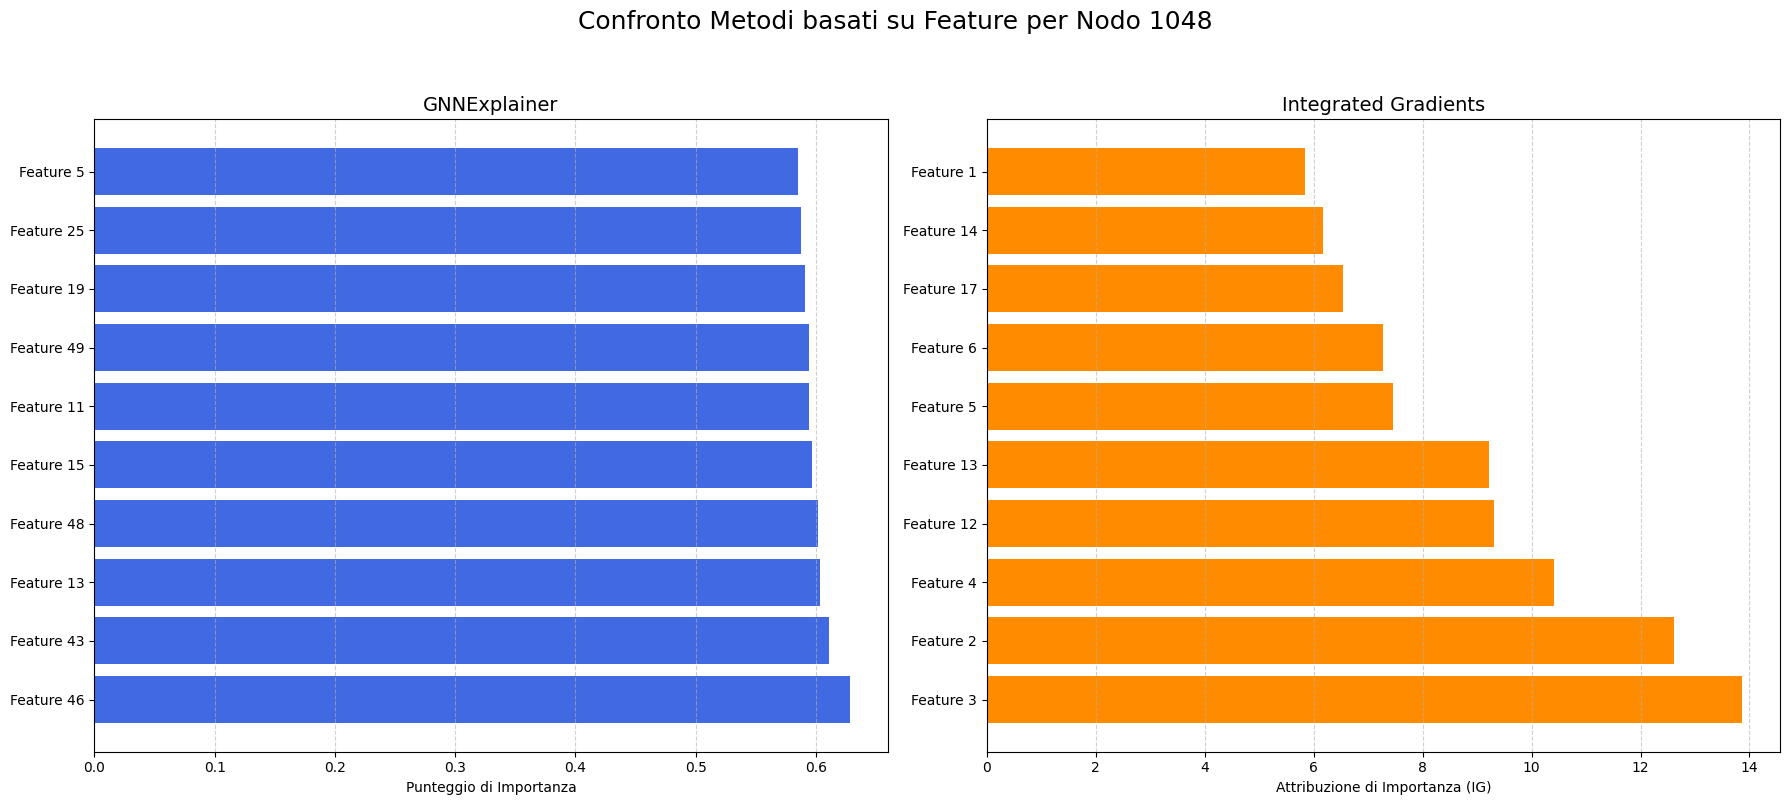

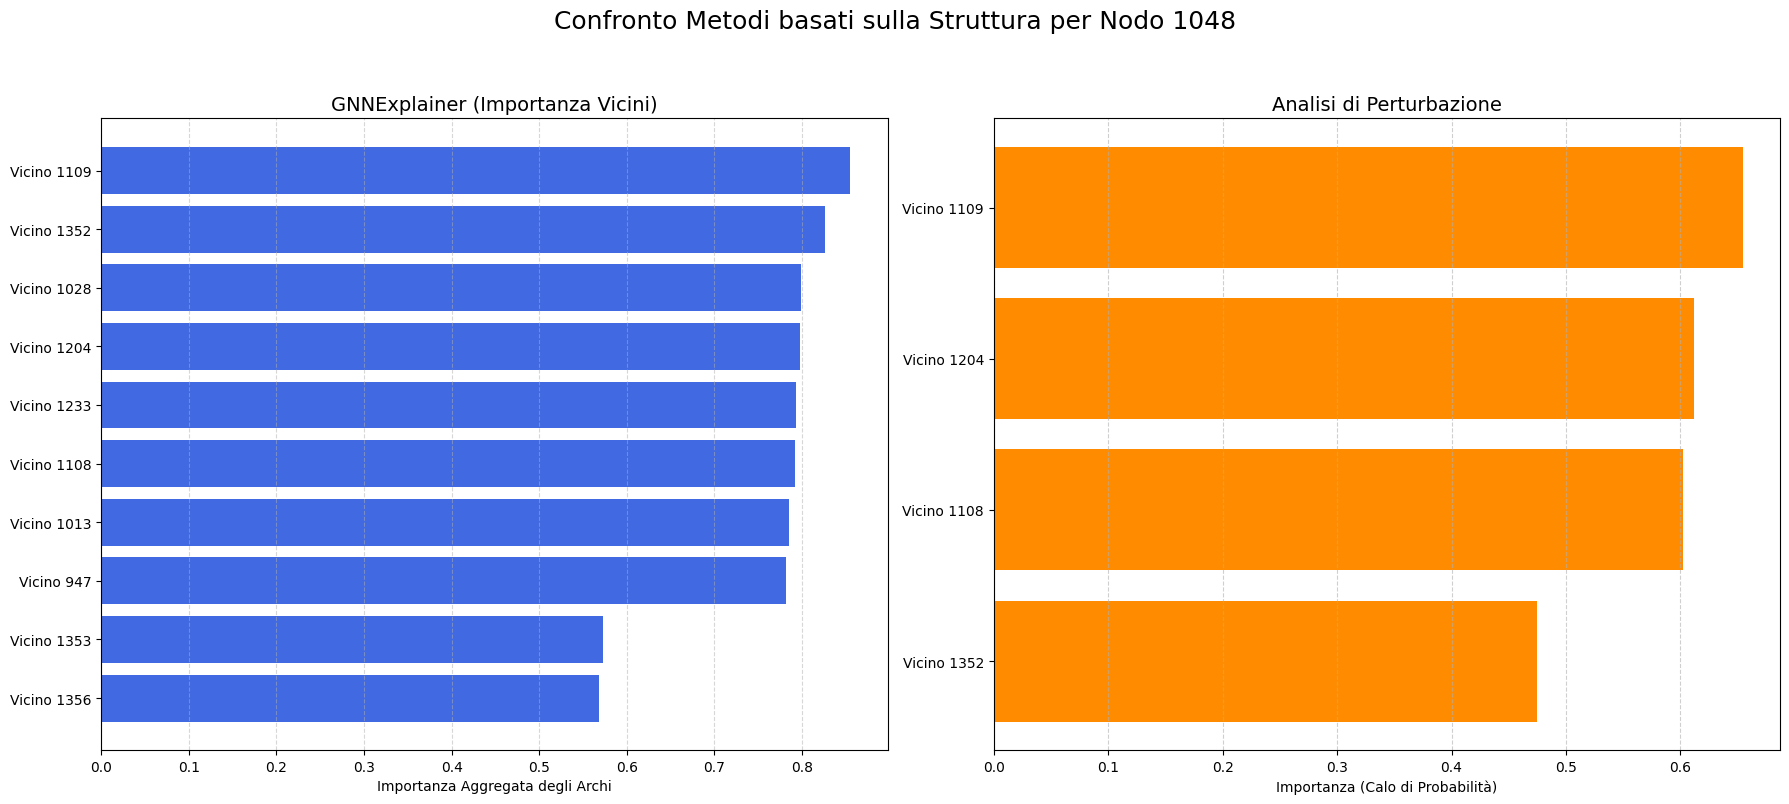

In [17]:
# ======================================================================
#            ANALISI COMPARATIVA VISIVA DEI METODI XAI
# ======================================================================
# Confronta visivamente i risultati dei diversi metodi di spiegabilità
# per identificare concordanze e discordanze nelle loro conclusioni.

import matplotlib.pyplot as plt
import numpy as np
print("--- Generazione dei grafici di confronto visivo ---")

# --- FIGURA 1: CONFRONTO SULL'IMPORTANZA DELLE FEATURE ---
# Compara i metodi che assegnano un punteggio di importanza a ciascuna feature
# del nodo target: GNNExplainer e Integrated Gradients.

fig1, axes1 = plt.subplots(1, 2, figsize=(18, 8), sharex=False) # sharex=False per assi indipendenti
fig1.suptitle(f"Confronto Metodi basati su Feature per Nodo {node_to_explain_index}", fontsize=18, y=1.0)
k_top = 10

# Grafico 1.1: GNNExplainer (Importanza Feature)
ax1 = axes1[0]
# Estrae e ordina le K feature più importanti secondo GNNExplainer.
feature_importances_gnn = explanation.node_mask[node_to_explain_index].cpu().numpy()
sorted_indices_gnn = np.argsort(feature_importances_gnn)[-k_top:]
# Disegna il grafico a barre orizzontale.
ax1.barh(np.arange(k_top), feature_importances_gnn[sorted_indices_gnn], color='royalblue')
ax1.set_yticks(np.arange(k_top), labels=[f"Feature {i}" for i in sorted_indices_gnn])
ax1.set_title("GNNExplainer", fontsize=14)
ax1.set_xlabel("Punteggio di Importanza")
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.invert_yaxis() # Inverte l'asse per mostrare la più importante in alto.

# Grafico 1.2: Integrated Gradients (Attribuzione Feature)
ax2 = axes1[1]
# Estrae e ordina le K feature più importanti secondo Integrated Gradients.
ig_values = saliency_map # Variabile salvata dalla cella di IG.
sorted_indices_ig = np.argsort(ig_values)[-k_top:]
# Disegna il grafico, usando un colore diverso per la distinzione.
ax2.barh(np.arange(k_top), ig_values[sorted_indices_ig], color='darkorange')
ax2.set_yticks(np.arange(k_top), labels=[f"Feature {i}" for i in sorted_indices_ig])
ax2.set_title("Integrated Gradients", fontsize=14)
ax2.set_xlabel("Attribuzione di Importanza (IG)")
ax2.grid(axis='x', linestyle='--', alpha=0.6)
ax2.invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- FIGURA 2: CONFRONTO SULL'IMPORTANZA DELLA STRUTTURA (VICINI) ---
# Compara i metodi che valutano l'importanza dei nodi vicini:
# GNNExplainer (attraverso l'importanza degli archi) e l'Analisi di Perturbazione.

fig2, axes2 = plt.subplots(1, 2, figsize=(18, 8), sharex=False)
fig2.suptitle(f"Confronto Metodi basati sulla Struttura per Nodo {node_to_explain_index}", fontsize=18, y=1.0)

# Grafico 2.1: GNNExplainer (Importanza Vicini)
ax3 = axes2[0]
# Poiché GNNExplainer valuta gli archi, aggreghiamo l'importanza per ogni vicino.
# Si sommano i punteggi di tutti gli archi connessi a un dato vicino.
edge_importances_gnn_agg = {}
edge_index_np = data.edge_index.cpu().numpy()
edge_mask_gnn = explanation.edge_mask.cpu().numpy()
for i in range(edge_index_np.shape[1]):
    u, v = int(edge_index_np[0, i]), int(edge_index_np[1, i])
    if u == node_to_explain_index:
        edge_importances_gnn_agg[v] = edge_importances_gnn_agg.get(v, 0) + edge_mask_gnn[i]
    elif v == node_to_explain_index:
        edge_importances_gnn_agg[u] = edge_importances_gnn_agg.get(u, 0) + edge_mask_gnn[i]

if edge_importances_gnn_agg:
    sorted_neighbors_gnn = sorted(edge_importances_gnn_agg.items(), key=lambda x: x[1])[-k_top:]
    neighbor_ids_gnn = [f"Vicino {i[0]}" for i in sorted_neighbors_gnn]
    importances_gnn_neighbors = [i[1] for i in sorted_neighbors_gnn]
    ax3.barh(neighbor_ids_gnn, importances_gnn_neighbors, color='royalblue')
    ax3.set_title("GNNExplainer (Importanza Vicini)", fontsize=14)
    ax3.set_xlabel("Importanza Aggregata degli Archi")
    ax3.grid(axis='x', linestyle='--', alpha=0.5)
else:
    ax3.text(0.5, 0.5, 'Dati non disponibili da\nGNNExplainer per i vicini.', ha='center', va='center')
    ax3.set_title("GNNExplainer (Importanza Vicini)", fontsize=14)

# Grafico 2.2: Analisi di Perturbazione dei Vicini
ax4 = axes2[1]
# Usa i risultati salvati dalla cella dell'analisi di perturbazione.
if 'sorted_neighbors' in locals() and sorted_neighbors:
    top_k_to_plot_pert = sorted_neighbors[:k_top]
    neighbor_ids_pert = [f"Vicino {i[0]}" for i in top_k_to_plot_pert]
    importances_pert = [i[1] for i in top_k_to_plot_pert]
    # Inverte i dati [::-1] per avere il più importante in alto, come negli altri grafici.
    ax4.barh(neighbor_ids_pert[::-1], importances_pert[::-1], color='darkorange')
    ax4.set_title("Analisi di Perturbazione", fontsize=14)
    ax4.set_xlabel("Importanza (Calo di Probabilità)")
    ax4.grid(axis='x', linestyle='--', alpha=0.6)
else:
    ax4.text(0.5, 0.5, 'Dati di perturbazione\nnon disponibili.', ha='center', va='center')
    ax4.set_title("Analisi di Perturbazione", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 6. Analisi Comparativa delle Metriche di Spiegabilità (XAI)

In questa sezione, valutiamo quantitativamente i metodi di spiegabilità utilizzati (GNNExplainer, Integrated Gradients, Analisi di occlusione dei vicini) per determinare quale fornisca le spiegazioni più fedeli e concise. Utilizzeremo due metriche principali:

1.  **Fedeltà (Fidelity):** Misura quanto una spiegazione riflette accuratamente il processo decisionale del modello. Calcoliamo il calo di probabilità per la classe corretta quando le feature più importanti identificate da ciascun metodo vengono "oscurate". Un calo maggiore indica una spiegazione più fedele.
2.  **Sparsità (Sparsity):** Misura la concisione della spiegazione. Una spiegazione più sparsa è più facile da interpretare. La calcoliamo come la frazione di feature con importanza vicina a zero.

L'obiettivo è trovare il metodo che offra il miglior compromesso tra fedeltà e interpretabilità (data dalla sparsità).

In [18]:
# ======================================================================
#            METRICHE XAI: DEFINIZIONE DELLE FUNZIONI
# ======================================================================
# Definisce le funzioni per la valutazione quantitativa delle spiegazioni
# basate sull'importanza delle feature (es. GNNExplainer, Integrated Gradients).

import numpy as np
import torch.nn.functional as F

def calculate_fidelity(model, x, edge_index, node_idx, target_class_idx, feature_importance_mask, top_k_fraction=0.2):
    """
    Calcola la Fedeltà (Fidelity) di una spiegazione.

    Questa metrica risponde alla domanda: "La spiegazione riflette fedelmente
    il comportamento del modello?".
    
    Il metodo consiste nel rimuovere (oscurare) le k feature più importanti 
    indicate dalla maschera e misurare il conseguente calo di probabilità 
    per la classe corretta.

    Interpretazione: Un punteggio ALTO (grande calo di probabilità) indica
    una spiegazione PIÙ FEDELE, poiché ha identificato feature cruciali.
    """
    # 1. Calcola la probabilità originale (baseline).
    with torch.no_grad():
        original_probs = F.softmax(model(x, edge_index.type(torch.int64)), dim=1)
        original_prob = original_probs[node_idx, target_class_idx].item()
        
    # 2. Identifica le top-k feature più importanti da rimuovere.
    num_features = x.shape[1]
    k = int(num_features * top_k_fraction)
    top_k_indices = np.argsort(feature_importance_mask)[-k:]
    
    # 3. Crea una versione perturbata dell'input oscurando le feature.
    x_perturbed = x.clone()
    x_perturbed[node_idx, top_k_indices] = 0.0
    
    # 4. Calcola la probabilità dopo la perturbazione.
    with torch.no_grad():
        perturbed_probs = F.softmax(model(x_perturbed, edge_index.type(torch.int64)), dim=1)
        perturbed_prob = perturbed_probs[node_idx, target_class_idx].item()
        
    # Il punteggio di fedeltà è il calo di probabilità.
    fidelity_score = original_prob - perturbed_prob
    return fidelity_score

def calculate_sparsity(feature_importance_mask):
    """
    Calcola la Sparsità (Sparsity) di una spiegazione.

    Questa metrica risponde alla domanda: "La spiegazione è concisa e facile
    da interpretare?".

    Il metodo calcola la frazione di feature a cui viene assegnata un'importanza
    quasi nulla (sotto una certa soglia, dopo normalizzazione).

    Interpretazione: Un punteggio ALTO indica una spiegazione PIÙ SPARSA,
    ovvero più semplice e focalizzata su poche feature chiave.
    """
    # Normalizza la maschera di importanza tra 0 e 1 per un confronto equo.
    mask_min, mask_max = np.min(feature_importance_mask), np.max(feature_importance_mask)
    if mask_max == mask_min: # Evita divisione per zero se la maschera è costante.
        return 0.0
    normalized_mask = (feature_importance_mask - mask_min) / (mask_max - mask_min)
    
    # Calcola la frazione di feature con importanza quasi nulla (es. < 0.01).
    sparsity_score = np.mean(normalized_mask < 0.01)
    return sparsity_score

print("Funzioni per il calcolo delle metriche di Fedeltà e Sparsità definite.")

Funzioni per il calcolo delle metriche di Fedeltà e Sparsità definite.



--- Calcolo delle metriche quantitative per il nodo 1048 ---


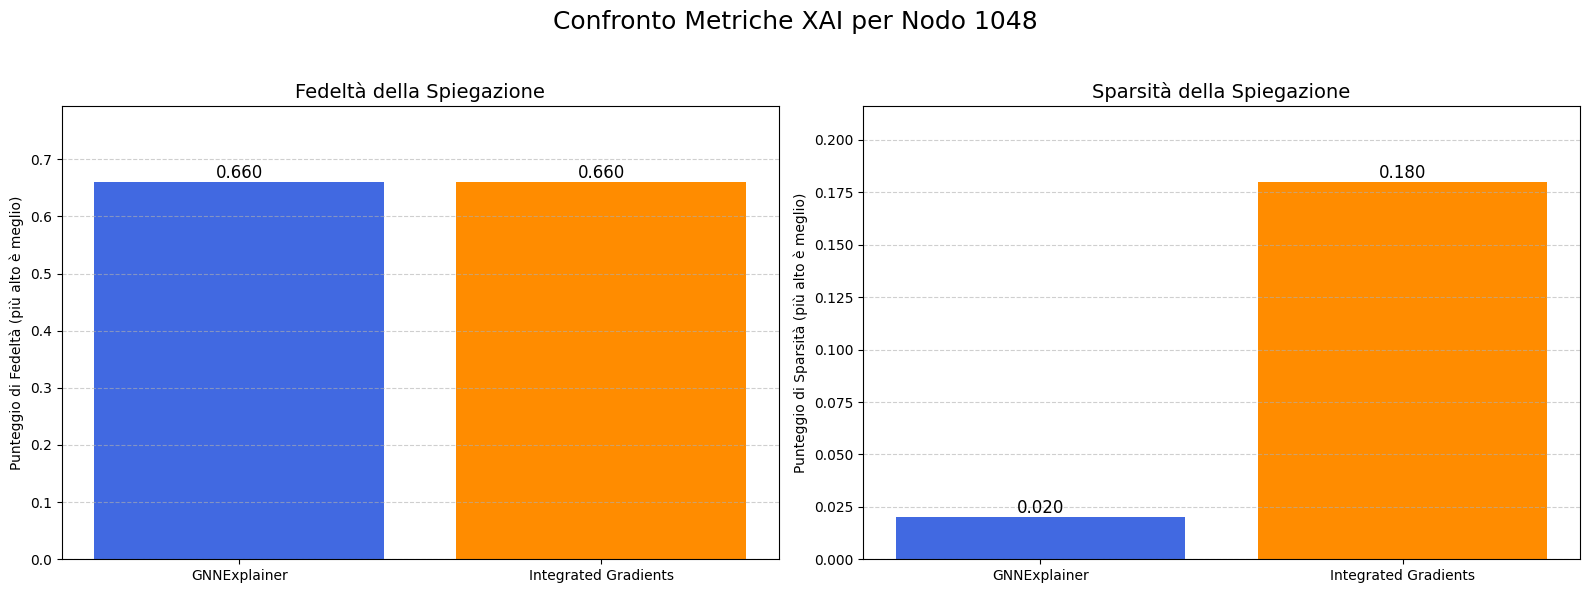


--- Riepilogo dei Risultati delle Metriche ---
Metodo                    | Fedeltà         | Sparsità       
------------------------------------------------------------
GNNExplainer              | 0.6604          | 0.0200         
Integrated Gradients      | 0.6604          | 0.1800         


In [19]:
# ======================================================================
#      ANALISI QUANTITATIVA: CALCOLO E CONFRONTO DELLE METRICHE
# ======================================================================
# Si applicano le funzioni definite in precedenza per calcolare e confrontare
# la Fedeltà e la Sparsità delle spiegazioni basate su feature.

print(f"\n--- Calcolo delle metriche quantitative per il nodo {node_to_explain_index} ---")

# --- 1. Preparazione dei Dati ---
# Recupera le maschere di importanza delle feature generate dai metodi XAI.
gnnexplainer_feature_mask = explanation.node_mask[node_to_explain_index].cpu().numpy()
ig_feature_mask = saliency_map # Contiene i risultati di Integrated Gradients.

# --- 2. Calcolo delle Metriche ---
# Fedeltà: misura quanto è affidabile la spiegazione. Punteggio più alto = migliore.
k_fraction_for_fidelity = 0.2 
fidelity_gnnexplainer = calculate_fidelity(model, data.x, data.edge_index, node_to_explain_index, target_class_idx, gnnexplainer_feature_mask, top_k_fraction=k_fraction_for_fidelity)
fidelity_ig = calculate_fidelity(model, data.x, data.edge_index, node_to_explain_index, target_class_idx, ig_feature_mask, top_k_fraction=k_fraction_for_fidelity)

# Sparsità: misura quanto è concisa la spiegazione. Punteggio più alto = migliore.
sparsity_gnnexplainer = calculate_sparsity(gnnexplainer_feature_mask)
sparsity_ig = calculate_sparsity(ig_feature_mask)

# --- 3. Visualizzazione Grafica dei Risultati ---
# Confronta i due metodi su entrambe le metriche tramite grafici a barre.
methods = ['GNNExplainer', 'Integrated Gradients']
fidelity_scores = [fidelity_gnnexplainer, fidelity_ig]
sparsity_scores = [sparsity_gnnexplainer, sparsity_ig]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Confronto Metriche XAI per Nodo {node_to_explain_index}', fontsize=18)

# Grafico per la Fedeltà
bars1 = ax1.bar(methods, fidelity_scores, color=['royalblue', 'darkorange'])
ax1.set_ylabel('Punteggio di Fedeltà (più alto è meglio)')
ax1.set_title('Fedeltà della Spiegazione', fontsize=14)
ax1.set_ylim(0, max(fidelity_scores) * 1.2 if fidelity_scores else 1)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
# Aggiunge il valore numerico sopra ogni barra.
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center', fontsize=12)

# Grafico per la Sparsità
bars2 = ax2.bar(methods, sparsity_scores, color=['royalblue', 'darkorange'])
ax2.set_ylabel('Punteggio di Sparsità (più alto è meglio)')
ax2.set_title('Sparsità della Spiegazione', fontsize=14)
ax2.set_ylim(0, max(sparsity_scores) * 1.2 if sparsity_scores else 1)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
# Aggiunge il valore numerico sopra ogni barra.
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center', fontsize=12)
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- 4. Riepilogo Tabellare ---
# Stampa una tabella sintetica dei risultati, ideale per report e tesi.
print("\n--- Riepilogo dei Risultati delle Metriche ---")
print(f"{'Metodo':<25} | {'Fedeltà':<15} | {'Sparsità':<15}")
print("-" * 60)
print(f"{methods[0]:<25} | {fidelity_scores[0]:<15.4f} | {sparsity_scores[0]:<15.4f}")
print(f"{methods[1]:<25} | {fidelity_scores[1]:<15.4f} | {sparsity_scores[1]:<15.4f}")

## Interpretazione della Generazione Automatica della Relazione

    Raccolta dei Dati: Il codice inizia raccogliendo tutti i risultati salienti ottenuti in precedenza: le feature e i vicini più importanti secondo ogni metodo (GNNExplainer, IG, Perturbazione) e i punteggi quantitativi di Fedeltà e Sparsità.

    Costruzione del Prompt: Questi dati vengono poi sintetizzati in un unico e dettagliato prompt. Al LLM viene assegnato il ruolo di "ricercatore esperto" e vengono fornite istruzioni precise su come analizzare i dati e strutturare la relazione finale.

    Generazione e Stampa: Infine, il prompt viene inviato al modello locale e la relazione generata viene stampata. L'obiettivo è ottenere un riassunto testuale che traduca i complessi risultati numerici e grafici in una valutazione diagnostica coerente e professionale.

In [20]:
# ======================================================================
#                             INTEGRAZIONE LLM
# ======================================================================

# ---  Configurazione del Client per LM Studio ---
# Si stabilisce la connessione con il server locale di LM Studio.
# È necessario che l'applicazione sia in esecuzione e il server avviato.

from openai import OpenAI

# Configurazione del client per puntare al server locale di LM Studio
try:
    client = OpenAI(base_url="http://127.0.0.1:1234/v1", api_key="not-needed")
    print("Connessione a LM Studio stabilita con successo.")
except Exception as e:
    print(f"ERRORE: Impossibile connettersi a LM Studio.")
    print("Verifica che LM Studio sia in esecuzione e che il server sia attivo sulla porta 1234.")

Connessione a LM Studio stabilita con successo.


In [ ]:
# ======================================================================
#         6. INTEGRAZIONE LLM: GENERAZIONE DELLA RELAZIONE FINALE
# ======================================================================

import torch.nn.functional as F
import numpy as np

print("\n--- Preparazione del prompt completo per l'LLM ---")

# --- 1. Estrazione di tutti i dati salienti (qualitativi e quantitativi) ---

# Contesto generale
target_node_class = classes[int(predicted_labels[node_to_explain_index].item())]
original_prob = F.softmax(all_logits, dim=1)[node_to_explain_index].max().item()

# Dati qualitativi - Feature
top_indices_gnn = np.argsort(gnnexplainer_feature_mask)[-5:][::-1]
top_features_gnn_str = ", ".join([f"Feature {i}" for i in top_indices_gnn])

ig_values = saliency_map # Contiene i risultati di Integrated Gradients
top_indices_ig = np.argsort(ig_values)[-5:][::-1]
top_features_ig_str = ", ".join([f"Feature {i}" for i in top_indices_ig])

# Dati qualitativi - Vicini
top_neighbors_gnn_str = ", ".join([str(n[0]) for n in sorted_neighbors_gnn[-3:]]) # Top 3 vicini da GNNExplainer
top_neighbors_pert_str = ", ".join([str(n[0]) for n in sorted_neighbors[:3]])   # Top 3 vicini da Perturbazione

# Dati quantitativi - Metriche
fidelity_gnn_str = f"{fidelity_gnnexplainer:.3f}"
sparsity_gnn_str = f"{sparsity_gnnexplainer:.3f}"
fidelity_ig_str = f"{fidelity_ig:.3f}"
sparsity_ig_str = f"{sparsity_ig:.3f}"


# --- 2. Costruzione del Prompt Finale e Dettagliato ---
user_content = f"""
Sei un ricercatore esperto in neuro-oncologia e Explainable AI (XAI). Il tuo compito è scrivere una relazione sintetica e professionale in italiano basata sui seguenti dati, analizzando la predizione di un modello GNN per una specifica regione cerebrale.

**Contesto Diagnostico:**
- ID Soggetto: {subject_id}
- Regione di Interesse (Nodo): ID {node_to_explain_index}
- Predizione del Modello GNN: '{target_node_class}' (Confidenza: {original_prob:.1%})

**Analisi Comparativa dei Metodi di Spiegabilità:**

1.  **Analisi basata sulle Feature:**
    -   **GNNExplainer:** Ha identificato come più importanti le seguenti feature -> {top_features_gnn_str}.
    -   **Integrated Gradients:** Ha identificato come più importanti le seguenti feature -> {top_features_ig_str}.

2.  **Analisi basata sulla Struttura del Grafo (Vicini):**
    -   **GNNExplainer (archi):** I vicini con le connessioni più importanti sono -> {top_neighbors_gnn_str}.
    -   **Analisi di Perturbazione:** Rimuovere questi vicini ha causato il maggior calo di probabilità -> {top_neighbors_pert_str}.

3.  **Valutazione Quantitativa dei Metodi (Metriche):**
    -   GNNExplainer: Fedeltà = {fidelity_gnn_str}, Sparsità = {sparsity_gnn_str}.
    -   Integrated Gradients: Fedeltà = {fidelity_ig_str}, Sparsità = {sparsity_ig_str}.
    (Nota: Fedeltà alta = affidabile; Sparsità alta = concisa).

**Istruzioni per la Relazione (massimo 5-6 frasi):**
- Inizia la relazione con: "L'analisi di spiegabilità per il nodo {node_to_explain_index} del soggetto {subject_id} fornisce le seguenti indicazioni:"
- Commenta brevemente se i metodi concordano sull'importanza delle feature e dei vicini.
- Basandoti sulle metriche, valuta quale metodo di spiegabilità basato su feature (GNNExplainer o IG) sembra più affidabile e/o interpretabile in questo caso.
- Concludi con un giudizio complessivo sulla robustezza della predizione del modello.
"""

# --- 3. Invia il prompt all'LLM e gestisci la risposta ---
print("Invio del prompt all'LLM...")
llm_response_text = ""
model_name = "local-model"
try:
    completion = client.chat.completions.create(
      model="local-model",
      messages=[
        {"role": "system", "content": "Sei un ricercatore esperto in neuro-oncologia e Explainable AI (XAI). Scrivi una relazione sintetica, tecnica e professionale in italiano, integrando e confrontando tutti i dati forniti."},
        {"role": "user", "content": user_content}
      ],
      temperature=0.6,
      timeout=220.0,
    )
    if completion and completion.choices:
        llm_response_text = completion.choices[0].message.content
        model_name = completion.model
    else:
        llm_response_text = "**Errore:** L'LLM non ha restituito una risposta valida."
except Exception as e:
    llm_response_text = f"**Errore:** Si è verificato un problema durante la chiamata all'LLM.\n\n*Dettagli:* `{e}`"

# --- 4. Stampa la Relazione Finale ---
print("\n" + "="*70)
print("   RELAZIONE DI SPIEGABILITÀ FINALE (Output dall'LLM)")
print("="*70)

print(f"\n{llm_response_text}\n")

print("-"*70)
print(f"Modello Utilizzato: {model_name}")
print("="*70)


--- Preparazione del prompt completo per l'LLM ---
Invio del prompt all'LLM...
